In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc


# read in protein data
protein = pd.read_csv("data/citeseq_pbmc/pro.csv") # 10k cells (protein)
# convert to AnnData
protein_adata = ad.AnnData(
    protein.to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein.columns


# read in RNA data
rna = mmread("data/citeseq_pbmc/rna.txt") # rna count as sparse matrix, 10k cells (RNA)
rna_names = pd.read_csv('data/citeseq_pbmc/citeseq_rna_names.csv')['names'].to_numpy()
# convert to AnnData
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names

# read in celltyle labels
metadata = pd.read_csv('data/citeseq_pbmc/meta.csv')
labels_l1 = metadata['celltype.l1'].to_numpy()
labels_l2 = metadata['celltype.l2'].to_numpy()

protein_adata.obs['celltype.l1'] = labels_l1
protein_adata.obs['celltype.l2'] = labels_l2
rna_adata.obs['celltype.l1'] = labels_l1
rna_adata.obs['celltype.l2'] = labels_l2


correspondence = pd.read_csv('data/protein_gene_conversion.csv')
correspondence.head()

rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])

rna_protein_correspondence = np.array(rna_protein_correspondence)

shared_gene_features = [pro for (pro, rna) in rna_protein_correspondence]
print(len(shared_gene_features))
shared_gene_features = list(set(shared_gene_features))
print("Final shared RNA: ",len(shared_gene_features))


rna_adata_copy = rna_adata.copy()
rna_not_touched = rna_adata.copy()
sc.pp.normalize_total(rna_adata_copy)
sc.pp.log1p(rna_adata_copy)
sc.pp.highly_variable_genes(rna_adata_copy, n_top_genes=2000)
highly_var_genes = list(set(rna_adata.var_names[rna_adata_copy.var.highly_variable==True]))
highly_var_genes_filtered = [gene for gene in highly_var_genes if gene not in shared_gene_features]
print("variable genes that are not shared: ", len(highly_var_genes_filtered))

all_gene_features = highly_var_genes_filtered+shared_gene_features
print("Total gene features: ", len(all_gene_features))
total_genes_indices = [i for i, gene in enumerate(rna_adata.var_names) if gene in all_gene_features]
rna_adata = rna_adata[:,total_genes_indices]


def get_mapping(p_adata, r_adata, rna_protein_correspondence):
    p_index = []
    r_index = []
    mapping_dict = {}
    for i in range(rna_protein_correspondence.shape[0]):
        match = rna_protein_correspondence[i]
        rna, pro = match
        p_idx = list(p_adata.var_names).index(pro)
        r_idx = list(r_adata.var_names).index(rna)
        p_index.append(p_idx)
        r_index.append(r_idx)
        mapping_dict[str(p_idx)] = r_idx
    return mapping_dict

mapping_dict = get_mapping(protein_adata,rna_adata,rna_protein_correspondence)

C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


180
Final shared RNA:  170


C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


variable genes that are not shared:  1911
Total gene features:  2081


In [2]:
import torch
from torch.utils.data import Dataset
import random
random.seed(42)

class ProteinRNAeditedDataset(Dataset):
    def __init__(self,adata_file,protein_adata,dict_mapping,unfiltered_data):
        self.protein_dataset = protein_adata.X
        self.data = adata_file
        self.dict_mapping = dict_mapping
        self.data = np.array(self.data.X.todense())
        self.local_mean, self.local_var = self.compute_library_size(self.data)

        shared_idx_protein = list(self.dict_mapping.keys())
        shared_idx_protein = list(map(int, shared_idx_protein))
        shared_protein_sample = self.protein_dataset[:,shared_idx_protein]
        
        shared_idx_rna = []
        for i in shared_idx_protein:
            shared_idx_rna.append(self.dict_mapping[str(i)])
        shared_rna_sample = self.data[:,shared_idx_rna]
        
        shared_idx_protein = list(self.dict_mapping.keys())
        self.shared_idx_protein = list(map(int, shared_idx_protein))
        unshared_protein_idx = set(range(self.protein_dataset.shape[1])) - set(self.shared_idx_protein)
        self.unshared_protein_idx = list(unshared_protein_idx)
        self.shared_idx_rna = []
        for i in shared_idx_protein:
            self.shared_idx_rna.append(self.dict_mapping[str(i)])
        unshared_rna_idx = set(range(self.data.shape[1])) - set(self.shared_idx_rna)
        self.unshared_rna_idx = list(unshared_rna_idx)
        
    def __len__(self):
        return 2*self.protein_dataset.shape[0]

    def __getitem__(self, idx):
        n = self.protein_dataset.shape[0]
        if idx < n:
            rna_idx = idx
            rna_sample = torch.Tensor(self.data[rna_idx])
            unshared_rna_sample = rna_sample[self.unshared_rna_idx]            
            shared_rna_sample = rna_sample[self.shared_idx_rna]
            return rna_sample,shared_rna_sample,1.0
        else:
            protein_idx = idx - n
            protein_sample = torch.Tensor(self.protein_dataset[protein_idx,:])
            shared_protein_sample = protein_sample[self.shared_idx_protein]
            unshared_protein_sample = protein_sample[self.unshared_protein_idx]
            return protein_sample,shared_protein_sample,0.0

    def compute_library_size(self, data):
        # print(data.shape)
        sum_counts = data.sum(axis=1)
        masked_log_sum = np.ma.log(sum_counts)
        if np.ma.is_masked(masked_log_sum):
            print(
                "Warning: This dataset has some empty cells, this might fail scVI inference. Data should be filtered with `my_dataset.filter_cells_by_count()"
            )
        log_counts = masked_log_sum.filled(0)
        local_mean = (np.mean(log_counts).reshape(-1, 1)).astype(np.float32)
        local_var = (np.var(log_counts).reshape(-1, 1)).astype(np.float32)

        local_mean = torch.Tensor(local_mean).reshape(-1)
        local_var = torch.Tensor(local_var).reshape(-1)
        return local_mean, local_var


# iter = 0
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset = ProteinRNAeditedDataset(rna_adata,protein_adata,mapping_dict,rna_adata_copy)

def collate_fn(batch):
    unshared,shared,indicators = zip(*batch)
    indicators = list(indicators)
    unshared = list(unshared)
    shared = list(shared)
    protein_unshared = [tensor for tensor, indicator in zip(unshared, indicators) if indicator == 0]
    rna_unshared = [tensor for tensor, indicator in zip(unshared, indicators) if indicator == 1]
    protein_shared = [tensor for tensor, indicator in zip(shared, indicators) if indicator == 0]
    rna_shared = [tensor for tensor, indicator in zip(shared,indicators) if indicator == 1]

    if rna_shared:
        rna_shared = torch.stack(rna_shared,dim=0)
        rna_unshared = torch.stack(rna_unshared,dim=0)
    else:
        rna_shared = torch.tensor([])
        rna_unshared = torch.tensor([])
    if protein_shared:
        protein_shared = torch.stack(protein_shared,dim=0)
        protein_unshared = torch.stack(protein_unshared,dim=0)
    else:
        protein_shared = torch.tensor([])
        protein_unshared = torch.tensor([])
        
    return protein_shared,rna_shared,protein_unshared,rna_unshared
    
train_dataloader = DataLoader(dataset, batch_size=256, shuffle=True,collate_fn=collate_fn)

Epoch: 0: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:12<00:00,  6.50it/s]


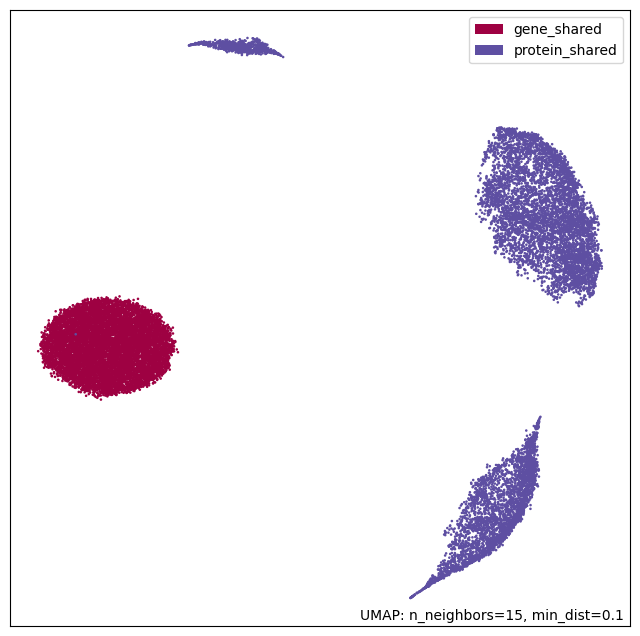

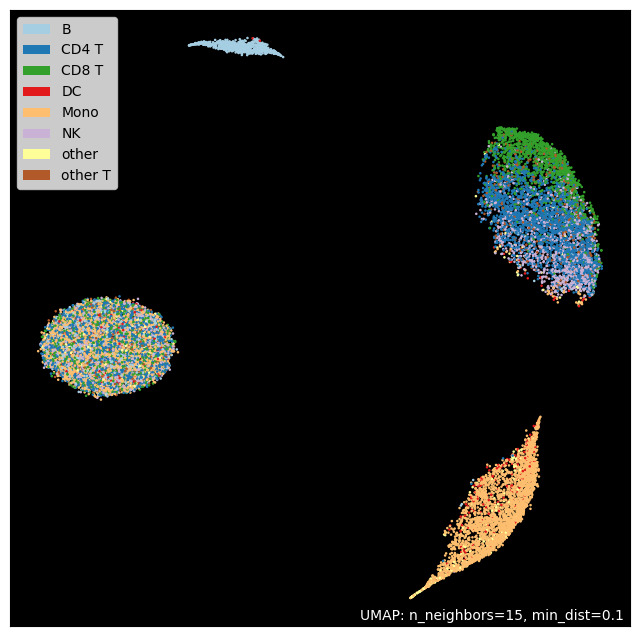

sharedloss: 1491.226068878174 || unsharedrloss: 4290.069747924805 || unsharedploss: 1680.289617919922 || embploss: 0.0 || embrloss: 0.0
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!
For All matchings: lv1 matching acc: 0.228,
lv2 matching acc: 0.186.
For All matchings: FOSCTTM score: 0.4987172199999999, 
Knn Alignment score: [0.0001 0.0003 0.0005 0.0006 0.0007 0.0007 0.0007 0.001  0.001  0.0011
 0.0011 0.0012 0.0013 0.0016 0.0017 0.0019 0.002  0.002  0.0022 0.0023
 0.0024 0.0027 0.0027 0.0027 0.0029 0.003  0.0032 0.0034 0.0035 0.0036
 0.0038 0.0041 0.0044 0.0046 0.0046 0.0046 0.0046 0.0047 0.0048 0.0048
 0.0048 0.0048 0.0051 0.0051 0.0051 0.0051 0.0052 0.0052 0.0052 0.0054
 0.0056 0.0058 0.0059 0.0059 0.006  0.006  0.0061 0.0061 0.0062 0.0062
 0.0063 0.0064 0.0064 0.0065 0.0066 0.0066 0.0067 0.0069 0.0069 0.0071
 0.0073 0.0073 0.0074 0.0075 0.0076 0.0076 0.0076 0.0078 0.0078 0.0079
 0.0081 0.0081 0.0

C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!
For all matchings after propagation: lv1 matching acc: 0.258,
lv2 matching acc: 0.142.


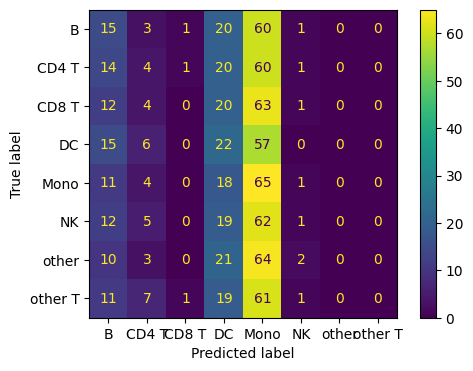

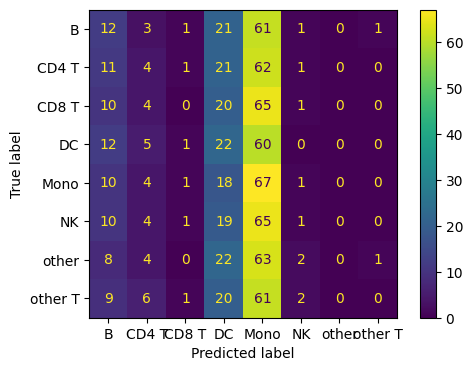

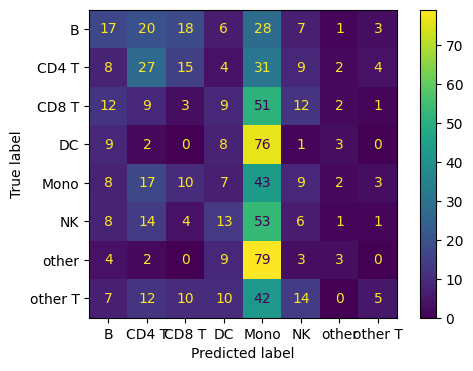

Epoch: 100: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:11<00:00,  6.78it/s]


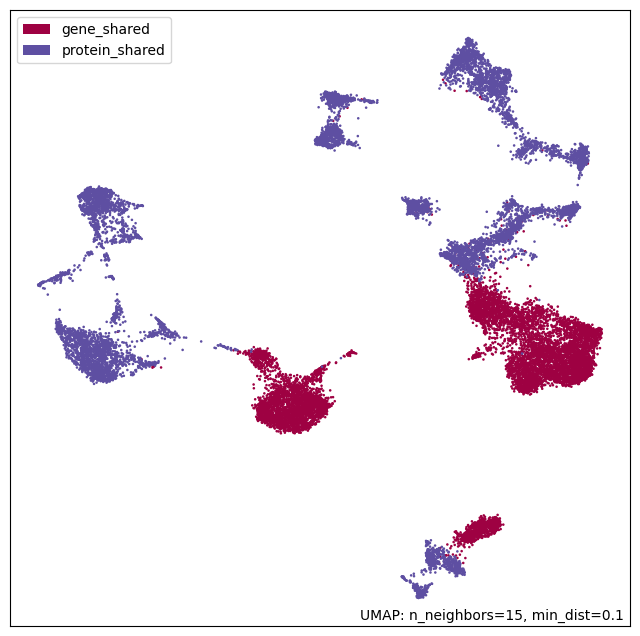

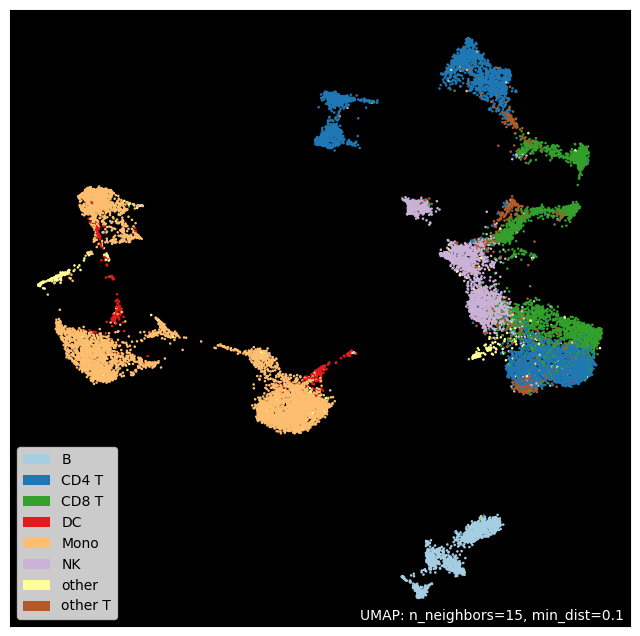

sharedloss: 529.690315246582 || unsharedrloss: 620.2281364440918 || unsharedploss: 602.4408569335938 || embploss: 0.0 || embrloss: 0.0
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!
For All matchings: lv1 matching acc: 0.628,
lv2 matching acc: 0.434.
For All matchings: FOSCTTM score: 0.28233678000000006, 
Knn Alignment score: [0.001  0.0015 0.0023 0.0034 0.0038 0.0042 0.0052 0.0059 0.007  0.0078
 0.0091 0.0098 0.0105 0.011  0.0116 0.0122 0.0126 0.0134 0.0136 0.0138
 0.0144 0.0148 0.0152 0.0157 0.016  0.0167 0.0172 0.0181 0.0192 0.0197
 0.0199 0.0203 0.0209 0.0214 0.0221 0.0223 0.0227 0.0231 0.0236 0.0242
 0.0251 0.0252 0.0255 0.0257 0.0262 0.027  0.0275 0.0281 0.0286 0.0296
 0.0301 0.0306 0.031  0.0313 0.0318 0.0324 0.033  0.0337 0.0339 0.0345
 0.0351 0.0353 0.0358 0.0366 0.0374 0.0381 0.0381 0.0385 0.0389 0.0397
 0.0402 0.0407 0.0412 0.0417 0.0421 0.0427 0.0433 0.0441 0.0444 0.0455
 0.0459 0.0465 0.0

C:\Users\tejas\anaconda3\envs\final_projectCS690env\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!
For all matchings after propagation: lv1 matching acc: 0.625,
lv2 matching acc: 0.438.


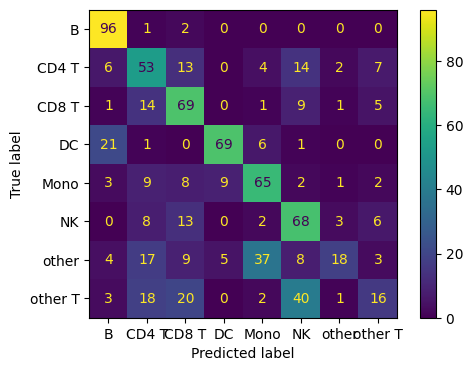

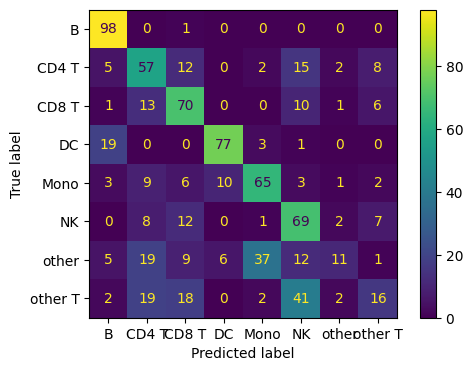

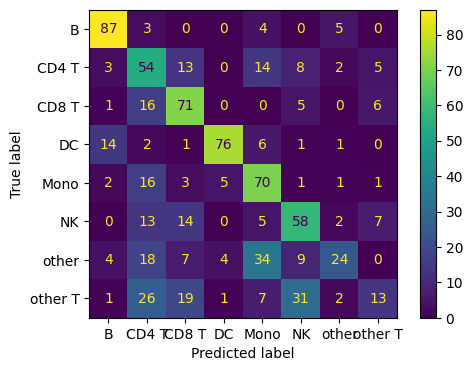

Epoch: 138:  15%|██████████▋                                                           | 12/79 [00:01<00:09,  6.83it/s]

In [ ]:
import torch.nn as nn
import torch
from scvi.models.vae import VAE_shared
from scvi.models.proteinvi import ProteinVI_shared
from scvi.models.totalvi import TOTALVI_shared
import torch.nn.functional as F
import umap.plot

from sklearn.metrics import adjusted_rand_score,accuracy_score
from sklearn.metrics import silhouette_score
import numpy as np
import umap
import anndata
import scanpy as sc
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
import metrics.match_utils as mu

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

nlayers = 2
#Unshared model protein
podel = ProteinVI_shared(224,224,latent_distribution="normal",log_variational=True,n_layers_encoder = nlayers,n_layers_decoder = nlayers)
#Unshared model RNA
rodel = VAE_shared(2081,2081,latent_distribution="normal",log_variational=True,n_layers = nlayers,reconstruction_loss = 'zinb')
#shared model protein-RNA
prodel = TOTALVI_shared(170,latent_distribution="normal",log_variational=True,n_layers_encoder = nlayers,n_layers_decoder = nlayers,reconstruction_loss_gene = "zinb")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
podel.to(device)
rodel.to(device)
prodel.to(device)


podel_params = filter(lambda p: p.requires_grad, podel.parameters())
rodel_params = filter(lambda p: p.requires_grad, rodel.parameters())
prodel_params = filter(lambda p: p.requires_grad, prodel.parameters())

optimizer_p = torch.optim.Adam(podel_params, lr=0.001, eps=0.01)
optimizer_r = torch.optim.Adam(rodel_params, lr=0.001, eps=0.01)
optimizer_pr = torch.optim.Adam(prodel_params, lr=0.001, eps=0.01)


Unshared_protein_loss = []
Unshared_rna_loss = []
Shared_loss = []
loss_emb_p = []
loss_emb_r = []

final_unshared_protein_loss = 0.0
final_unshared_rna_loss = 0.0
final_shared_loss = 0.0
final_loss_emb_p = 0.0
final_loss_emb_r = 0.0
kl_weight = 0.0

def l2_normalize_batch_pytorch(batch):
    norm = torch.norm(batch, dim=1, keepdim=True)
    normalized_batch = batch / norm
    return normalized_batch
    
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

def CLIP_loss(rna_total,rna_unshared):
    
    text_embeddings = l2_normalize_batch_pytorch(rna_total)
    image_embeddings = l2_normalize_batch_pytorch(rna_unshared)
    temperature = 1.0
    logits = (text_embeddings @ image_embeddings.T) 
    images_similarity = image_embeddings @ image_embeddings.T
    texts_similarity = text_embeddings @ text_embeddings.T
    targets = F.softmax(
        (images_similarity + texts_similarity) / 2, dim=-1
    )
    texts_loss = cross_entropy(logits, targets, reduction='none')
    images_loss = cross_entropy(logits.T, targets.T, reduction='none')
    loss =  (images_loss + texts_loss) / 2.0 
    return loss.mean()


def distance_pred(latent1 , latent2):
    distances = torch.zeros(latent1.shape[0], latent2.shape[0])
    for i in range(latent1.shape[0]):
        distances[i,:] = torch.norm(latent2 - latent1[i], dim=1)  # Calculate Euclidean distance
    return distances

kl_weight = 0.0
for epoch in range(501):
    final_unshared_protein_loss = 0.0
    final_unshared_rna_loss = 0.0
    final_shared_loss = 0.0
    final_loss_emb_p = 0.0
    final_loss_emb_r = 0.0
    
    for y_shared,x_shared,y_unshared,x_unshared in tqdm(train_dataloader,desc="Epoch: {}".format(epoch)):
        optimizer_p.zero_grad()
        optimizer_r.zero_grad()
        optimizer_pr.zero_grad()
        y_shared = y_shared.to(device)
        x_shared = x_shared.to(device)
        y_unshared = y_unshared.to(device)
        x_unshared = x_unshared.to(device)
        drna_shared = dataset[0][1].view(1,-1).to(device)
        drna_unshared = dataset[0][0].view(1,-1).to(device)
        dprotein_shared = dataset[10000][1].view(1,-1).to(device)
        dprotein_unshared = dataset[10000][0].view(1,-1).to(device)
        y_shared = torch.cat([y_shared,dprotein_shared],dim=0)
        y_unshared = torch.cat([y_unshared,dprotein_unshared],dim=0)
        x_shared = torch.cat([x_shared,drna_shared],dim=0)
        x_unshared = torch.cat([x_unshared,drna_unshared],dim=0)
        local_mean = dataset.local_mean.reshape(-1,1).expand(x_shared.shape[0], 1).to(device)
        local_var = dataset.local_var.reshape(-1,1).expand(x_shared.shape[0], 1).to(device)

        ## forward pass of unshared network of RNA
        loss_r,output_r,_ = rodel(x_unshared,local_mean,local_var)
        unshared_rna_loss = torch.mean(loss_r[0]+kl_weight*loss_r[1])
        with torch.no_grad():
            outputs = prodel(x_shared,y_shared,local_mean,local_var)
        loss_embedd_r = CLIP_loss(outputs[5][:, :-1],output_r)
        unshared_rna_loss +=  loss_embedd_r
        final_unshared_rna_loss += unshared_rna_loss.item()
        unshared_rna_loss.backward()
        optimizer_r.step()

        ## forward pass of unshared network of proteins
        output_p = podel(y_unshared)
        unshared_protein_loss = torch.mean(output_p[0] + kl_weight*output_p[1] + output_p[2])
        with torch.no_grad():
            outputs = prodel(x_shared,y_shared,local_mean,local_var)
        loss_embedd_p = CLIP_loss(output_p[3],outputs[6][:,:-1])
        unshared_protein_loss += loss_embedd_p
        final_unshared_protein_loss += unshared_protein_loss.item()
        unshared_protein_loss.backward()
        optimizer_p.step()
        
        ## forward pass of shared_network
        outputs = prodel(x_shared,y_shared,local_mean,local_var)
        shared_loss = torch.mean(outputs[0] + outputs[3]) + kl_weight*torch.mean(outputs[2]) + torch.mean(outputs[1] + outputs[4])
        with torch.no_grad():
            _,output_r,_f = rodel(x_unshared,local_mean,local_var)
            output_p = podel(y_unshared)
        loss_embedd_r = CLIP_loss(outputs[5][:, :-1],output_r)
        loss_embedd_p = CLIP_loss(output_p[3],outputs[6][:,:-1])
        shared_loss += loss_embedd_r
        shared_loss += loss_embedd_p
        final_shared_loss += shared_loss.item()
        shared_loss.backward()
        optimizer_pr.step()
            
        
    kl_weight = min(1.0,(epoch+1)/500)
    Unshared_protein_loss.append(final_unshared_protein_loss)
    Unshared_rna_loss.append(final_unshared_rna_loss)
    Shared_loss.append(final_shared_loss)
    loss_emb_p.append(final_loss_emb_p)
    loss_emb_r.append(final_loss_emb_r)

    if epoch % 100 == 0:
        """Testing loop and visualisation saving"""
        with torch.no_grad():
            protein_data = torch.Tensor(dataset.protein_dataset)
            rna_data = torch.Tensor(dataset.data)
            # print(protein_data.shape, rna_data.shape)
            protein_shared = protein_data[:,dataset.shared_idx_protein].to(device)
            protein_unshared = protein_data.to(device)
            rna_shared = rna_data[:,dataset.shared_idx_rna].to(device)
            rna_unshared = rna_data.to(device)
            shared_tensor_mean = dataset.local_mean.reshape(-1,1).expand(10000, 1).to(device)
            shared_tensor_var = dataset.local_var.reshape(-1,1).expand(10000, 1).to(device) 
            outputs = prodel(rna_shared,protein_shared,shared_tensor_mean,shared_tensor_var)
            outputs_1 = podel(protein_unshared)
            _,outputs_2,_ = rodel(rna_unshared,shared_tensor_mean,shared_tensor_var)
            z_protein_unshared = outputs_1
            z_gene_unshared = outputs_2[3]
            labels_rna_matrix = rna_adata.obs.copy()
            z_gene_shared = outputs[5][:, :-1]
            z_protein_shared = outputs[6][:, :-1]            
            tensor1 = z_gene_shared.cpu()
            tensor2 = z_protein_shared.cpu()
            concatenated_tensor = np.concatenate((tensor1, tensor2), axis=0)
            n_components = 2
            mapper = umap.UMAP(n_components=n_components).fit(concatenated_tensor)
            concatenated_labels = np.array(["gene_shared"] * 10000 + ["protein_shared"] * 10000)
            umap.plot.points(mapper,labels=concatenated_labels)
            plt.show()
            tensor1_labels = np.array(labels_rna_matrix['celltype.l1'])
            concatenated_labels = np.concatenate((tensor1_labels,tensor1_labels), axis=0)
            umap.plot.points(mapper,labels=concatenated_labels,color_key_cmap='Paired', background='black')
            plt.show()
            print("sharedloss: {} || unsharedrloss: {} || unsharedploss: {} || embploss: {} || embrloss: {}".format(final_shared_loss/80,final_unshared_rna_loss/80,final_unshared_protein_loss/80,final_loss_emb_p/80,final_loss_emb_r/80))
            rna_latents = tensor1.numpy()
            protein_latents = tensor2.numpy()
            mu.get_all_metrics(rna_latents, protein_latents,labels_l1, labels_l2, dim_use = 20, k_max=100, metric='euclidean', assignment_type='mindist', filter_prop=0.3, verbose=True)